# Project: Wrangling and Analyze Data (WeRateDog)

> WeRateDog is a Twitter handle that rate dog, upload dog image with a short description and give its followers a chance to like and re-tweet them. They are unique for using improper fractions as rating scores.  We asked WeRateDog for their twitter-archive-enhanced and they mailed it to us named twitter-archive-enhanced. I programmatically downloaded, opened it, and observed it contained basic information but not everything. Twitter-archive-enhanced lacked essential information like favorite and re-tweet counts. Also, it doesn’t contain information about the breed but thanks to Udacity for classifying the dog image uploaded using neural network procedure and saving it as image-prediction. 

In [1]:
# import the libraries

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO

In [2]:
# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions

# consumer_key = 'hidden'
# consumer_secret = 'hidden'
# access_token = 'hidden'
# access_secret = 'hidden'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

## Data Gathering
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
# load the datasets
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

## Data Assessment

In [4]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Quality
1. incomplete data (no favorite count, no retweet count)
2. inconsistent way of representing missing values (NaN and None)
3. Some columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` contains little observation

### Tidiness
1. dog age (doggo, fluffer, pupper, and puppo) is in four columns instead of one

In [5]:
archive_df.shape

(2356, 17)

There are 2356 tweet_id and 17 variables

In [6]:
archive_df.duplicated().sum()

0

There is no duplicated entry (tweet)

In [7]:
# check the number of tweet_ID
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

2356

In [8]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Quality
4. timestamp datatype is object and tweet_id is int

In [9]:
archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

* rating numerator > 15 and ratiing numerator == 0 has frequency <= 2

In [10]:
# Extract rating numerator > 15 and rating_numerator == 0 for visual inspection
rating_numerator_with_issue = archive_df[(archive_df['rating_numerator'] > 15) | (archive_df['rating_numerator'] == 0)][['tweet_id', 'text', 'rating_numerator']]
rating_numerator_with_issue.head(10) 

,tweet_id,text,rating_numerator
55,881633300179243008,@roushfenway These are good dogs but 17/10 is ...,17
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420
189,855860136149123072,@s8n You tried very hard to portray this good ...,666
290,838150277551247360,@markhoppus 182/10,182
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960
315,835152434251116546,When you're so blinded by your systematic plag...,0
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who liv...",75
433,820690176645140481,The floofs have been released I repeat the flo...,84
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",75


### Quality 
5. erronous rating score for most of the rating_numerator > 15 and the rating numerator == 0 

In [11]:
archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

* aside 10, other denominators have a frequency <= 3

In [12]:
# extract denominator order than 10 for visual inspection
rating_denominator_with_issue = archive_df[archive_df.rating_denominator != 10][['tweet_id', 'text', 'rating_denominator']]
rating_denominator_with_issue.head(10)

,tweet_id,text,rating_denominator
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,0
342,832088576586297345,@docmisterio account started on 11/15/15,15
433,820690176645140481,The floofs have been released I repeat the flo...,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is...",11
902,758467244762497024,Why does this never happen at my front door......,150
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",11
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,20
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,50


### Quality
6. erronous rating score for most of the rating_denominator != 10


In [13]:
archive_df.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

### Quality
7. Source written as link instead of exact name of the source

In [14]:
archive_df[archive_df.name.str.islower()]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

### Quality
8. wrong dog name ('a', 'such', 'quite' etc)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [15]:
# url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# response = requests.get(url)

# with open(os.path.join('image_pediction.tsv'), 'wb') as file:
#     image_prediction = file.write(response.content)

image_prediction_df = pd.read_csv('image_pediction.tsv', sep = '\t')
image_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Tidiness

2. image_prediction_df should be part of the archive table 
3. Multiple beeds name (p1, p2, and p3) predicted for a dog 

In [16]:
image_prediction_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

There is no null value

In [17]:
image_prediction_df.duplicated().sum()

0

There is no duplicated row

In [18]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality
5. tweet_id datatype is int



3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [19]:
# counter = 0
# fail_dict = {}
# start = timer()
# with open('tweet.txt', 'w') as file:
#     for tweet_id in tweet_ids:
#         counter += 1
#         print(str(counter) + ': ' + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode = 'extended')
#             print('success')
#             json.dump(tweet._json, file)
#             file.write('\n')
#         except tweepy.errors.TweepyException as e:
#             print('fail')
#             fail_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fail_dict)

In [20]:
tweet_list = []
with open("tweet.txt") as p:
    for line in p:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        year = data['created_at'].split(' ')[-1]
        tweet_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

tweet_df = pd.DataFrame(tweet_list)

In [21]:
tweet_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6975,33709
1,892177421306343426,5276,29238
2,891815181378084864,3466,21982
3,891689557279858688,7197,36812
4,891327558926688256,7721,35192
...,...,...,...
2322,666049248165822465,36,88
2323,666044226329800704,115,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112


### Tidiness
2. Tweet_df should be part of archive_df

In [22]:
tweet_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2460.095832,7030.298668
std,6.820795e+16,4166.298825,10924.330914
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1221.000000
50%,7.178418e+17,1144.000000,3038.000000
75%,7.986547e+17,2846.000000,8569.000000
max,8.924206e+17,70378.000000,144334.000000


In [23]:
tweet_df.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

### Quality 
5. tweet_id is int

## Clean

#### Quality one
* incomplete data (no favorite count, no retweet count) 

#### define

* Join archive_df, image_prediction_df and tweet_df on 'tweet_id' to create a new variable called complete_df

#### code

In [24]:
archve_df_new = pd.merge(left = archive_df, right = tweet_df, on = 'tweet_id', how = 'inner')
complete_df = pd.merge(left = archve_df_new, right = image_prediction_df, on = 'tweet_id', how = 'inner')

#### Test

In [25]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2057 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2057 non-null   object 
 4   source                      2057 non-null   object 
 5   text                        2057 non-null   object 
 6   retweeted_status_id         71 non-null     float64
 7   retweeted_status_user_id    71 non-null     float64
 8   retweeted_status_timestamp  71 non-null     object 
 9   expanded_urls               2057 non-null   object 
 10  rating_numerator            2057 non-null   int64  
 11  rating_denominator          2057 non-null   int64  
 12  name                        2057 non-null   object 
 13  doggo                       2057 

In [26]:
# make a copy of the complete dataframe 
new_complete_df = complete_df.copy()

#### Quality two
* inconsistent way of representing missing values (NaN and None)

#### define
* replace None with np.nan to unify the representation of the missing values 

#### code

In [27]:
new_complete_df.replace('None', np.nan, inplace = True)

#### Test

In [28]:
assert 'None' not in new_complete_df

In [29]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2057 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2057 non-null   object 
 4   source                      2057 non-null   object 
 5   text                        2057 non-null   object 
 6   retweeted_status_id         71 non-null     float64
 7   retweeted_status_user_id    71 non-null     float64
 8   retweeted_status_timestamp  71 non-null     object 
 9   expanded_urls               2057 non-null   object 
 10  rating_numerator            2057 non-null   int64  
 11  rating_denominator          2057 non-null   int64  
 12  name                        1486 non-null   object 
 13  doggo                       78 no

#### Quality three
* Some columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`, `img_num`, and `expanded_urls` contains little observation

#### define 
* drop columns with little or no relevant information. The columns are: ["in_reply_to_status_id", "in_reply_to_user_id", 
"retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "img_num", "expanded_urls"]

#### Code

In [30]:
col_names = ["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "img_num", "expanded_urls"]
new_complete_df.drop(labels = col_names, axis = 1, inplace = True)

#### Test

In [31]:
for col_name in col_names:
    assert col_name not in new_complete_df.columns

In [32]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2057 non-null   int64  
 1   timestamp           2057 non-null   object 
 2   source              2057 non-null   object 
 3   text                2057 non-null   object 
 4   rating_numerator    2057 non-null   int64  
 5   rating_denominator  2057 non-null   int64  
 6   name                1486 non-null   object 
 7   doggo               78 non-null     object 
 8   floofer             8 non-null      object 
 9   pupper              221 non-null    object 
 10  puppo               24 non-null     object 
 11  retweet_count       2057 non-null   int64  
 12  favorite_count      2057 non-null   int64  
 13  jpg_url             2057 non-null   object 
 14  p1                  2057 non-null   object 
 15  p1_conf             2057 non-null   float64
 16  p1_dog

#### Quality four
* timestamp datatype is object and tweet_id is int

#### definition 
* strip off the last '+0000' from timestamp, convert its datatype to datetime datetype using pd.to_datetime() function and rename it to tweet_date 
* convert tweet_id datatype to string


#### code

In [33]:
# strip off +0000 from timestamp 

new_complete_df.timestamp = new_complete_df.timestamp.str.split('+', expand = True)[0].str.strip()

# convert timestamp to datetime datatype
new_complete_df.timestamp = pd.to_datetime(new_complete_df['timestamp'])

# rename timestamp as tweet_date

new_complete_df.rename(columns = {'timestamp': 'tweet_date'}, inplace = True)


#### Test

In [34]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2057 non-null   int64         
 1   tweet_date          2057 non-null   datetime64[ns]
 2   source              2057 non-null   object        
 3   text                2057 non-null   object        
 4   rating_numerator    2057 non-null   int64         
 5   rating_denominator  2057 non-null   int64         
 6   name                1486 non-null   object        
 7   doggo               78 non-null     object        
 8   floofer             8 non-null      object        
 9   pupper              221 non-null    object        
 10  puppo               24 non-null     object        
 11  retweet_count       2057 non-null   int64         
 12  favorite_count      2057 non-null   int64         
 13  jpg_url             2057 non-null   object      

### Quality 5 & 6
* erroneous rating score for most of the rating_denominator != 10
* erroneous rating score for most of the rating_numerator > 15 and the rating numerator == 0 

#### define

* combine the tweet_id of rating_numerator_with_issue and rating_denominator_with_issue
* set the index of new_complete_df to tweet_id
* drop the tweet_id with issue
* then reset the index
* calculate rating = rating_numerator/rating_denominator
* drop rating_numerator and rating_denominator

#### code

In [35]:
# extract denominator order than 10 for visual inspection
rating_denominator_df = new_complete_df[new_complete_df.rating_denominator != 10][['tweet_id', 'text', 'rating_denominator']]

# Extract rating numerator > 15 and rating_numerator == 0 for visual inspection
rating_numerator_df = new_complete_df[(new_complete_df['rating_numerator'] > 15) | (new_complete_df['rating_numerator'] == 0)][['tweet_id', 'text', 'rating_numerator']]

# combine the tweet_id of prob_rating_denominator and prob_rating_numerator
tweet_id_with_rating_issue = pd.Series(list(rating_denominator_df.tweet_id) + list(rating_numerator_df.tweet_id)).unique()

# set the index of new_complete_df to tweet_id
new_complete_df.set_index('tweet_id', inplace = True)

# drop the tweet_id with issue
new_complete_df.drop(labels = tweet_id_with_rating_issue, axis = 0, inplace = True)

# reset the index
new_complete_df = new_complete_df.reset_index()

# calculate rating = rating_numerator/rating_denominator
new_complete_df['dog_rating'] = new_complete_df['rating_numerator']/new_complete_df['rating_denominator']

# drop rating_numerator and rating_denominator
new_complete_df.drop(columns = ['rating_numerator', 'rating_denominator'], axis = 1, inplace = True)

#### Test

In [36]:
for tweet_id in tweet_id_with_rating_issue:
    assert tweet_id not in new_complete_df.tweet_id

In [37]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2032 non-null   int64         
 1   tweet_date      2032 non-null   datetime64[ns]
 2   source          2032 non-null   object        
 3   text            2032 non-null   object        
 4   name            1477 non-null   object        
 5   doggo           78 non-null     object        
 6   floofer         8 non-null      object        
 7   pupper          220 non-null    object        
 8   puppo           24 non-null     object        
 9   retweet_count   2032 non-null   int64         
 10  favorite_count  2032 non-null   int64         
 11  jpg_url         2032 non-null   object        
 12  p1              2032 non-null   object        
 13  p1_conf         2032 non-null   float64       
 14  p1_dog          2032 non-null   bool          
 15  p2  

#### Quality 7
* Source written as link instead of exact name of the source

#### define
* loop through souce column, replace each of the links with their corresponding value:
    * '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>' = 'iphone'
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>' = 'twitter_web'
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>' = 'vine'
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>' = 'tweetdeck'

#### code

In [38]:
source_list = []
for source in new_complete_df.source:
    if source == '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':
        source_name = 'iphone'
    elif source == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':
        source_name = 'twitter_web'
    elif source == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':
        source_name ='vine'
    elif source == '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':
        source_name = 'tweetdeck'
    else:
        source_name = np.nan
    source_list.append(source_name)
new_complete_df.source = source_list

#### test

In [39]:
new_complete_df.source.value_counts()

iphone         1993
twitter_web      30
tweetdeck         9
Name: source, dtype: int64

#### Quality 8
8. wrong dog name ('a', 'such', 'quite' etc)

#### define
* replace all non-name in the name columns with np.nan

#### code

In [40]:
mis_named = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space']
for i in range(len(new_complete_df)):
    if new_complete_df.loc[i, 'name'] in mis_named:
        new_complete_df.loc[i, 'name'] = np.nan
    else:
        new_complete_df.loc[i, 'name'] = new_complete_df.loc[i, 'name']

#### test

In [41]:
names = new_complete_df.name.value_counts()
for name in names.index:
    assert not name.islower()

#### Tidiness 1
* dog age (doggo, fluffer, pupper, and puppo) is in four columns instead of one

#### define
* use the values of dog age (doggo, fluffer, pupper, and puppo) to create another column, rename it to dog_name and drop (doggo, fluffer, pupper, and puppo) columns

#### code

In [42]:
def dog_ages(): 
    """A function that creates a new column, dog_age, 
    from the values of ('doggo', 'floofer', 'pupper', 'puppo'), 
    then insert the result in the position 8 in new_complete_df and lastly drop
    ('doggo', 'floofer', 'pupper', 'puppo') columns"""
    
    dog_age = []
    for row in new_complete_df.itertuples():
        age_value = np.nan
        if row.doggo == 'doggo':
            age_value = 'doggo'
        elif row.floofer == 'floofer':
            age_value = 'floofer'
        elif row.pupper == 'pupper':
            age_value = 'pupper'
        elif row.puppo == 'puppo':
            age_value = 'puppo'
        elif (row.doggo == np.nan) and (row.floofer == np.nan) and (row.pupper == np.nan) and (row.puppo == np.nan):
            age_value = np.nan
        dog_age.append(age_value)
    new_complete_df.insert(8, 'dog_age', dog_age)
    return new_complete_df.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], axis = 1, inplace = True) 
dog_ages()

#### Test

In [43]:
dropped_columns = ['doggo', 'floofer', 'pupper', 'puppo']
for dropped_column in dropped_columns:
    assert dropped_column not in new_complete_df.columns

In [44]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2032 non-null   int64         
 1   tweet_date      2032 non-null   datetime64[ns]
 2   source          2032 non-null   object        
 3   text            2032 non-null   object        
 4   name            1380 non-null   object        
 5   dog_age         317 non-null    object        
 6   retweet_count   2032 non-null   int64         
 7   favorite_count  2032 non-null   int64         
 8   jpg_url         2032 non-null   object        
 9   p1              2032 non-null   object        
 10  p1_conf         2032 non-null   float64       
 11  p1_dog          2032 non-null   bool          
 12  p2              2032 non-null   object        
 13  p2_conf         2032 non-null   float64       
 14  p2_dog          2032 non-null   bool          
 15  p3  

#### Tidiness 2
* Multiple beeds name (p1, p2, and p3) predicted for a dog 

#### define
* create a new column called dog_beed. Loop through the rows in the new_complete_df dataframe,
if the prediction is True, pick the beed predicted with the highest confidence. Else label dog_beed as np.nan

In [45]:
complete_df.iloc[34:38, :]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
34,884925521741709313,NaN,NaN,2017-07-12 00:01:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Earl. He found a hat. Nervous about wh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884925521...,...,1,Italian_greyhound,0.259916,True,American_Staffordshire_terrier,0.198451,True,Staffordshire_bullterrier,0.127725,True
35,884876753390489601,NaN,NaN,2017-07-11 20:47:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lola. It's her first time outside. Mus...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884876753...,...,1,chow,0.822103,True,Norwich_terrier,0.106075,True,Norfolk_terrier,0.037348,True
36,884562892145688576,NaN,NaN,2017-07-11 00:00:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevin. He's just so happy. 13/10 what ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884562892...,...,1,pug,0.546406,True,French_bulldog,0.404291,True,Brabancon_griffon,0.044002,True
37,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,...,1,Pembroke,0.993225,True,Cardigan,0.003216,True,Chihuahua,0.002081,True


In [46]:
new_complete_df.iloc[34:38, :]

,tweet_id,tweet_date,source,text,name,dog_age,retweet_count,favorite_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_rating
34,884925521741709313,2017-07-12 00:01:00,iphone,This is Earl. He found a hat. Nervous about wh...,Earl,NaN,14950,67065,https://pbs.twimg.com/media/DEfjEaNXkAAtPlj.jpg,Italian_greyhound,0.259916,True,American_Staffordshire_terrier,0.198451,True,Staffordshire_bullterrier,0.127725,True,1.2
35,884876753390489601,2017-07-11 20:47:12,iphone,This is Lola. It's her first time outside. Mus...,Lola,NaN,4641,24311,https://pbs.twimg.com/media/DEe2tZXXkAAwyX3.jpg,chow,0.822103,True,Norwich_terrier,0.106075,True,Norfolk_terrier,0.037348,True,1.3
36,884562892145688576,2017-07-11 00:00:02,iphone,This is Kevin. He's just so happy. 13/10 what ...,Kevin,NaN,3896,21257,https://pbs.twimg.com/media/DEaZQkfXUAEC7qB.jpg,pug,0.546406,True,French_bulldog,0.404291,True,Brabancon_griffon,0.044002,True,1.3
37,884441805382717440,2017-07-10 15:58:53,iphone,"I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,4778,23792,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,Pembroke,0.993225,True,Cardigan,0.003216,True,Chihuahua,0.002081,True,1.4


#### code

In [47]:
confidence = []
breed_predicted = []
for row in new_complete_df.itertuples():
    if (row.p1_dog == np.nan) and (row.p2_dog == np.nan) and (row.p3_dog == np.nan):
        breed_conf = np.nan
        breed_name = np.nan
        tweet_id = row.tweet_id
    breed_conf = 0
    if (row.p1_dog == True) and (row.p1_conf > breed_conf):
        breed_conf = row.p1_conf
        breed_name = row.p1
        tweet_id = row.tweet_id
    if (row.p2_dog == True) and (row.p2_conf > breed_conf):
        breed_conf = row.p2_conf
        breed_name = row.p2
        tweet_id = row.tweet_id
    if (row.p3_dog == True) and (row.p3_conf > breed_conf):
        breed_conf = row.p3_conf
        breed_name = row.p3
        tweet_id = row.tweet_id
    if (row.p1_dog == False) and (row.p2_dog == False) and (row.p3_dog == False):
        breed_conf = np.nan
        breed_name = np.nan
        tweet_id = row.tweet_id

    breed_predicted.append({'breed_name': breed_name,
                            'breed_conf': breed_conf,
                            'tweet_id': tweet_id})
dog_prediction_df = pd.DataFrame(breed_predicted)
new_complete_df = pd.merge(left = new_complete_df, right = dog_prediction_df, on = 'tweet_id')
new_complete_df.drop(columns = ["p1", "p1_conf", "p1_dog", "p2", "p2_conf", "p2_dog", "p3", "p3_conf", "p3_dog"], axis = 1, inplace = True)


#### Test

In [48]:
new_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 2031
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2032 non-null   int64         
 1   tweet_date      2032 non-null   datetime64[ns]
 2   source          2032 non-null   object        
 3   text            2032 non-null   object        
 4   name            1380 non-null   object        
 5   dog_age         317 non-null    object        
 6   retweet_count   2032 non-null   int64         
 7   favorite_count  2032 non-null   int64         
 8   jpg_url         2032 non-null   object        
 9   dog_rating      2032 non-null   float64       
 10  breed_name      1715 non-null   object        
 11  breed_conf      1715 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 206.4+ KB


In [49]:
new_complete_df.shape

(2032, 12)

## Storing Data

In [50]:
new_complete_df.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

#### Insight 1: Are top 10 most favored the top 10 most re-tweeted dog breed?

In [51]:
# top 10 most favored dog breed

top_10_favorite = new_complete_df.groupby('breed_name')['favorite_count'].max().nlargest(10).to_frame()

top_10_re_tweet = new_complete_df.groupby('breed_name')['retweet_count'].max().nlargest(10).to_frame()


# display top_10_favorite and top_10_re_tweet side by side
from IPython.display import display_html 

top_10_favorite_styler = top_10_favorite.style.set_table_attributes("style='display:inline'").set_caption('top_10_favorite table')
top_10_re_tweet_styler = top_10_re_tweet.style.set_table_attributes("style='display:inline'").set_caption('top_10_re_tweet table')

display_html(top_10_favorite_styler._repr_html_()+top_10_re_tweet_styler._repr_html_(), raw=True)

,favorite_count
breed_name,
Labrador_retriever,144334
Lakeland_terrier,123624
Chihuahua,111268
French_bulldog,108489
Eskimo_dog,106854
English_springer,92550
standard_poodle,82433
malamute,80329
golden_retriever,73749


#### Observation

##### Favorite_count did not correspond with the retweet_count
* Labrodor_retriever has both the highest favorite_count and retweet_count
* Lakeland_terrier is the breed with the second highest favorite_count but is the fourth most retweeted.
* Eskimo_dog has the second highest most retweet count but was the fifth most favorite breed.
* Whippet (tenth) and cocker_spaniel (seventh) on the top 10 retweet_count are not among the top 10 favorite_count
* Malamute (eighth) and Golden_retriever (nineth) on the top 10 favorite_count table are not among the top 10 retweet_count


#### Reference 

[reference of the code to put the table side by side](https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side#:~:text=To%20display%20two%20DataFrames%20side%20by%20side%20you,HTML%20representation%20through%20the%20display_html%20method%20from%20IPython.)

#### Insight 2: Is dog breed with the highest re-tweet from the age class with the highest average rating ? 

In [52]:
# dog age with their average rating 
new_complete_df.groupby('dog_age')['dog_rating'].mean().sort_values(ascending = False)

dog_age
floofer    1.200000
puppo      1.200000
doggo      1.183333
pupper     1.067464
Name: dog_rating, dtype: float64

#### observations
* floolfer and puppo has the highest average rating of 1.2
* doggo came second with 1.183333

In [53]:
# highest retweet_count
max_retweet_count = new_complete_df['retweet_count'].max()

# dog age of the breed with the highest retweet_count
dog_name_highest_retweet = new_complete_df[new_complete_df['retweet_count'] == max_retweet_count]['dog_age']

print(dog_name_highest_retweet.values, 'has the highest retweet_count')

['doggo'] has the highest retweet_count


#### Observation
##### The age of the breed with the highest retweet_count is not in the dog_age class with the highest rating
* floofer and puppo has the highest rating with the value of 1.2
* dog with the highest retweet_count belong to the dog_age class doggo which has average rating of 1.183333

#### Insight  3: Which tweet source has the highest average rating of dog?

In [54]:
new_complete_df.groupby('source')['dog_rating'].mean().sort_values(ascending= False)

source
tweetdeck      1.122222
iphone         1.060311
twitter_web    1.006667
Name: dog_rating, dtype: float64

In [55]:
new_complete_df.source.value_counts()

iphone         1993
twitter_web      30
tweetdeck         9
Name: source, dtype: int64

#### Observation
* tweetdeck is the souce use to tweet dogs with the highest average rating
* iphone came second

### visualization 1: what is the major source of the tweet?

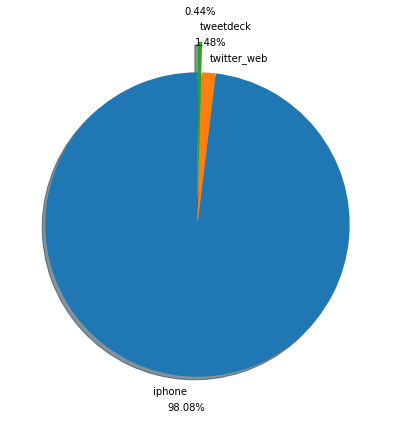

In [56]:
tweet_source = new_complete_df.source.value_counts()

plt.figure(figsize = (12,7))
plt.pie(x =tweet_source, labels = tweet_source.index, startangle = 90, explode = [0, 0, 0.2], shadow = True, autopct = '%.2f%%', pctdistance = 1.2);
plt.savefig('source.png')

#### Download the image of the top 5 dog breed with favourite counts

In [57]:
# top_5_favorite_count = top_10_favorite.favorite_count[:5]
# top_5_favorite_count_df = new_complete_df[new_complete_df.favorite_count.isin(top_5_favorite_count)]


# picture_folder = 'top_5_favorite' 

# if not os.path.exists(picture_folder):
#     os.makedirs(picture_folder)

# # download the image of dogs with the highest favourite
# for i in top_5_favorite_count_df.index:
#     url = top_5_favorite_count_df.loc[i, 'jpg_url']
#     name = top_5_favorite_count_df.loc[i, 'breed_name']
    
#     response = requests.get(url)
#     i = Image.open(BytesIO(response.content))
#     image_file_format = url.split('.')[-1]
#     i.save(picture_folder + "/" + name+ "." + image_file_format)
#     print(name)